In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', '..')))

from src.evpa_rotation.loader import load_data
from src.evpa_rotation.angles import adjust_angles
from src.evpa_rotation.plotter import plot_bayesian_blocks_extrema_filled_segments,plot_sub_intervals
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
file_path = os.path.abspath(os.path.join('..', '..', 'data', 'monitoring_data.csv'))
data = load_data(file_path)

data = load_data(file_path)
print(f"Loaded {len(data)} data points.")
data.head()


Loaded 4111 data points (S/N ≥ 3).
Loaded 4111 data points (S/N ≥ 3).
Loaded 4111 data points.


,J2000_name,Julian_date,Q/I_inst,err_Q/I_inst,U/I_inst,err_U/I_inst,Q/I,err_Q/I,U/I,err_U/I,PD[%],err_PD[%],EVPA[deg],err_EVPA[deg],MJD,Time_Diff
0,RBPLJ0006-0623,2.456550e+06,0.066,0.006,-0.124,0.006,0.063,0.008,-0.126,0.007,14.1,0.7,-31.8,1.4,56549.0353,NaN
1,RBPLJ0006-0623,2.456572e+06,0.204,0.009,-0.002,0.009,0.205,0.009,-0.009,0.012,20.5,0.9,-1.3,1.3,56571.9417,22.9064
2,RBPLJ0006-0623,2.456589e+06,0.287,0.011,-0.091,0.009,0.285,0.012,-0.102,0.014,30.3,1.2,-9.8,1.1,56588.8694,16.9277
3,RBPLJ0006-0623,2.456593e+06,0.308,0.010,-0.128,0.009,0.304,0.011,-0.139,0.014,33.5,1.2,-12.3,1.0,56592.9344,4.0650
4,RBPLJ0006-0623,2.456599e+06,0.310,0.004,-0.146,0.004,0.306,0.008,-0.157,0.012,34.4,0.9,-13.6,0.7,56598.8857,5.9513


In [3]:
data['Adjusted_EVPA'] = adjust_angles(data['EVPA[deg]'].tolist(), data['err_EVPA[deg]'].tolist())
data[['EVPA[deg]', 'Adjusted_EVPA']].head(100)


,EVPA[deg],Adjusted_EVPA
0,-31.8,-31.8
1,-1.3,-1.3
2,-9.8,-9.8
3,-12.3,-12.3
4,-13.6,-13.6
...,...,...
129,28.2,-151.8
130,-59.3,-239.3
131,52.6,-307.4
132,-47.0,-227.0


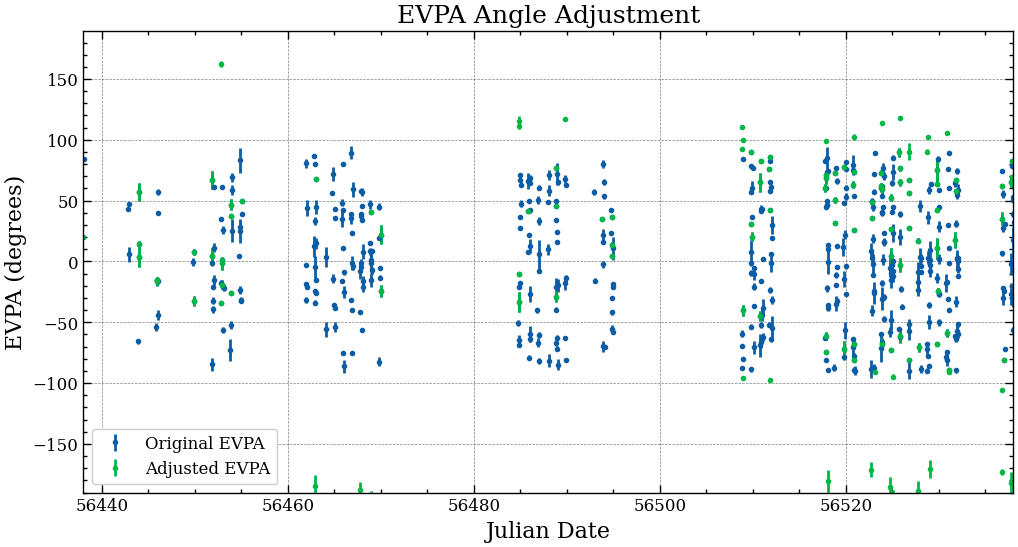

In [15]:
plt.figure(figsize=(12, 6))
plt.errorbar(data['MJD'], data['EVPA[deg]'], yerr=data['err_EVPA[deg]'],linestyle='',marker='.',label='Original EVPA')
plt.errorbar(data['MJD'], data['Adjusted_EVPA'],  yerr=data['err_EVPA[deg]'],linestyle='',marker='.',label='Adjusted EVPA')
plt.xlabel('Julian Date')
plt.ylabel('EVPA (degrees)')
plt.ylim(data['EVPA[deg]'].min()-100,data['EVPA[deg]'].max()+100)
plt.xlim(data['MJD'].min(),data['MJD'].min()+100)

plt.legend()
plt.title('EVPA Angle Adjustment')
plt.show()


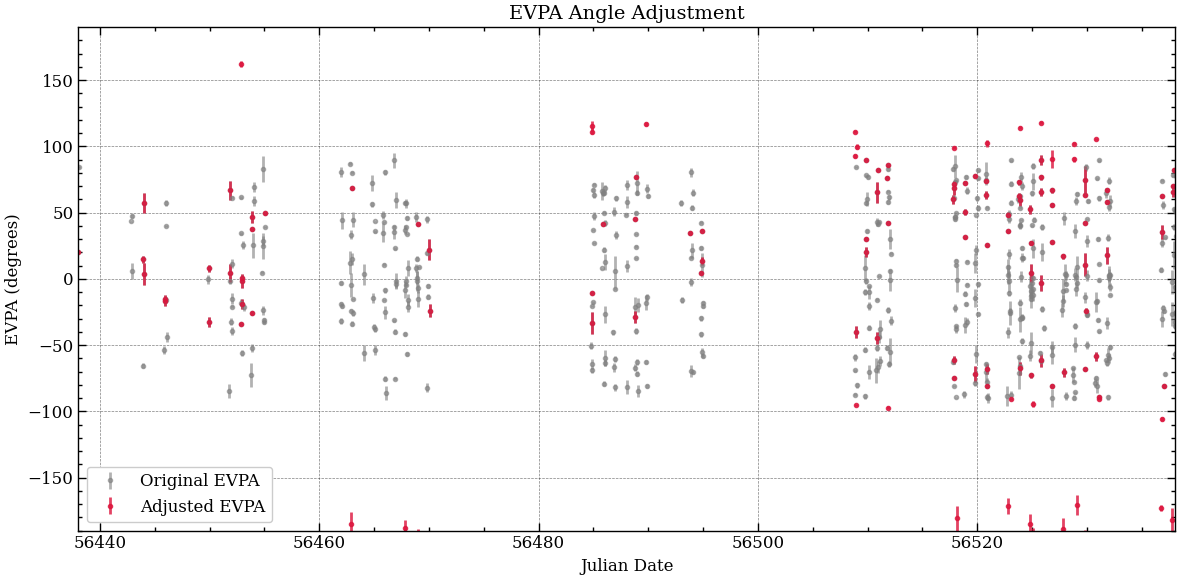

In [20]:
plt.figure(figsize=(12, 6))

# Original EVPA
plt.errorbar(
    data['MJD'], data['EVPA[deg]'], yerr=data['err_EVPA[deg]'],
    fmt='.', color='gray', alpha=0.6, label='Original EVPA'
)

# Adjusted EVPA
plt.errorbar(
    data['MJD'], data['Adjusted_EVPA'], yerr=data['err_EVPA[deg]'],
    fmt='.', color='crimson', alpha=0.8, label='Adjusted EVPA'
)

# Labels and limits
plt.xlabel('Julian Date', fontsize=12)
plt.ylabel('EVPA (degrees)', fontsize=12)
plt.ylim(data['EVPA[deg]'].min() - 100, data['EVPA[deg]'].max() + 100)
plt.xlim(data['MJD'].min(), data['MJD'].min() + 100)

# Styling
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.title('EVPA Angle Adjustment', fontsize=14)
plt.tight_layout()
plt.show()


In [33]:
def plot_evpa_bayesian_blocks(df, mjd_col='MJD', evpa_col='Adjusted_EVPA', err_col='err_EVPA[deg]', p0=0.01):
    # Ομαδοποίηση για μοναδικές τιμές MJD
    df = df.groupby(mjd_col, as_index=False).agg({
        evpa_col: 'mean',
        err_col: 'mean'
    }).sort_values(mjd_col)

    t = df[mjd_col].values
    y = df[evpa_col].values
    yerr = df[err_col].values

    edges = bayesian_blocks(t, y, sigma=yerr, fitness='measures', p0=p0)

    means = []
    for i in range(len(edges)-1):
        mask = (t >= edges[i]) & (t < edges[i+1]) if i < len(edges)-2 else (t >= edges[i]) & (t <= edges[i+1])
        means.append(np.mean(y[mask]))

    step_x = np.repeat(edges, 2)[1:-1]
    step_y = np.repeat(means, 2)

    plt.figure(figsize=(12,6))
    plt.errorbar(t, y, yerr=yerr, fmt='.', color='gray', alpha=0.5, label='Adjusted EVPA')
    plt.step(step_x, step_y, where='post', color='orange', linewidth=2, label='Bayesian Blocks')
    plt.xlabel('MJD')
    plt.ylabel('EVPA (degrees)')
    plt.title('EVPA with Bayesian Blocks')
    plt.xlim(t.min(),t.min()+30)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


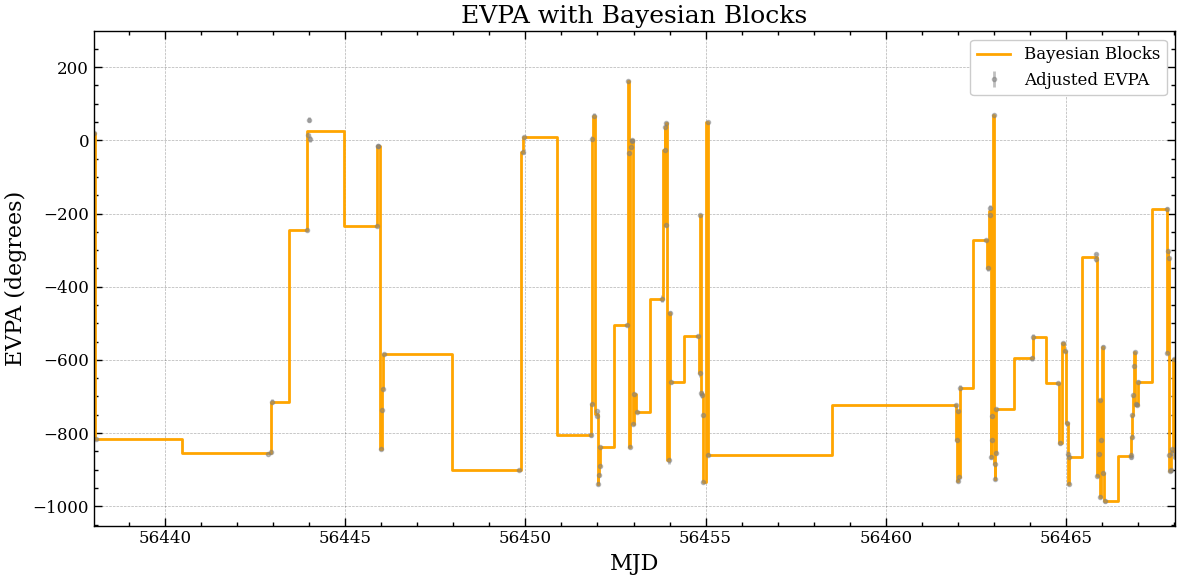

In [34]:
plot_evpa_bayesian_blocks(data)


In [35]:
def plot_evpa_bayesian_blocks(df, mjd_col='MJD', evpa_col='EVPA[deg]', err_col='err_EVPA[deg]', p0=0.001):
    # Ομαδοποίηση για μοναδικές τιμές MJD
    df = df.groupby(mjd_col, as_index=False).agg({
        evpa_col: 'mean',
        err_col: 'mean'
    }).sort_values(mjd_col)

    t = df[mjd_col].values
    y = df[evpa_col].values
    yerr = df[err_col].values

    edges = bayesian_blocks(t, y, sigma=yerr, fitness='measures', p0=p0)

    means = []
    for i in range(len(edges)-1):
        mask = (t >= edges[i]) & (t < edges[i+1]) if i < len(edges)-2 else (t >= edges[i]) & (t <= edges[i+1])
        means.append(np.mean(y[mask]))

    step_x = np.repeat(edges, 2)[1:-1]
    step_y = np.repeat(means, 2)

    plt.figure(figsize=(12,6))
    plt.errorbar(t, y, yerr=yerr, fmt='.', color='gray', alpha=0.5, label='Adjusted EVPA')
    plt.step(step_x, step_y, where='post', color='orange', linewidth=2, label='Bayesian Blocks')
    plt.xlabel('MJD')
    plt.ylabel('EVPA (degrees)')
    plt.title('EVPA with Bayesian Blocks')
    plt.xlim(t.min(),t.min()+30)

    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


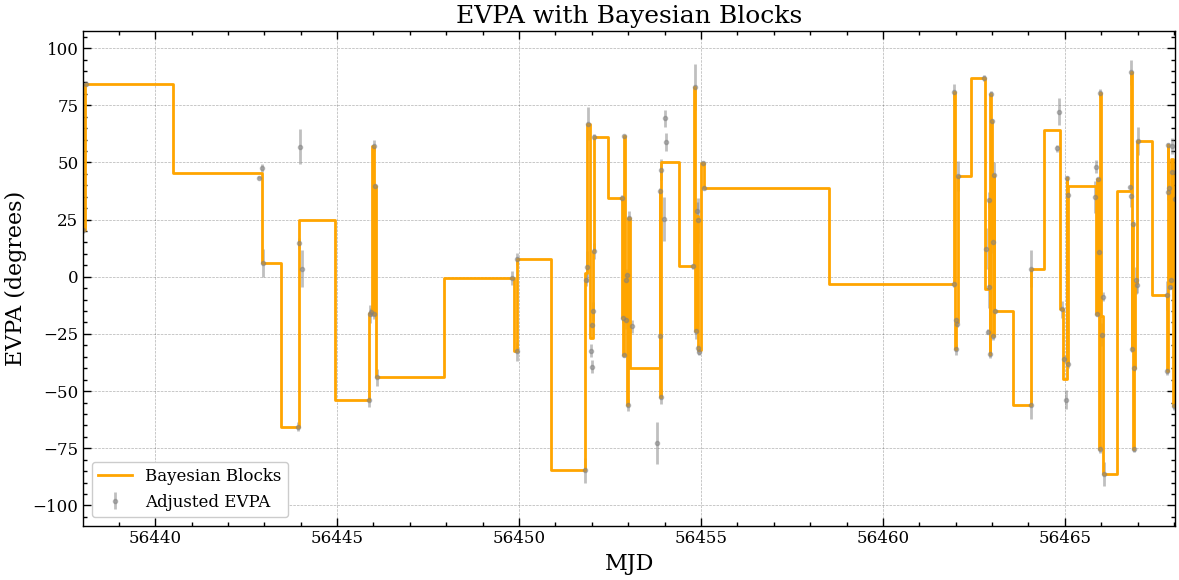

In [36]:
plot_evpa_bayesian_blocks(data)
